# Análise Exploratória

## Sumário

- Importações necessárias
- Dados disponíveis
  - Carregamento dos dados
- Perguntas
  - Análise sobre o arquivo de exemplos
    - 1. Qual o número total de perguntas?
    - 2. Qual o número total de respostas?
    - 3. Todas as perguntas correspondem diretamente à uma resposta?
    - 4. Qual o tamanho médio das perguntas enviadas pelos clientes/usuários?
    - 5. Qual o tamanho médio das respostas dadas?
    - 6. Qual o número médio de perguntas diferentes feitas juntas?
    - 7. Quais palavras são mais frequentes?
    - 8. Qual é a distribuição das classes de intenções das perguntas?
    - 9. Existe uma Correlação entre o Tamanho da Pergunta e o Tipo de Resposta Dada?
    - 10. Qual é a quantidade de tokens por pergunta?
    - 11. Qual é a quantidade de tokens por resposta?
  - Análise com Pandas Profilling
  - Análise sobre o FAQ
    - 1. Qual o número total de perguntas
    - 2. Qual o número total de respostas
    - 3. Todas as perguntas correspondem diretamente à uma resposta?
    - 4. Todas as perguntas correspondem diretamente à uma resposta?
    - 5. Qual o tamanho médio das respostas listadas?
    - 6. Quais palavras são mais frequentes?
    - 7. Qual é a distribuição das classes de intenções das perguntas?
    - 8. Qual é a quantidade de tokens por pergunta?
    - 9. Qual é a quantidade de tokens por resposta?
  - Análise com Pandas Profilling(FAQ)

## Importações necessárias

In [207]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip -q

  Preparing metadata (setup.py) ... done


In [208]:
!pip install googletrans==4.0.0-rc1

In [209]:
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from googletrans import Translator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from pandas_profiling import ProfileReport

## Dados disponíveis

Para a análise exploratória a ser feita, serão utilizados os dados disponíveis no site oficial do FAQ da Brastel (https://brastelremit.jp/eng/help) e os exemplos de perguntas e respostas presentes no csv fornecido pelo cliente.

### Carregamento dos dados

In [210]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [211]:
os.listdir('/content/drive/Shareddrives/grupo3moshi')

['chats_clients.csv',
 'FAQ-brastel.csv',
 'chats_clients.gsheet',
 'faq_translated.csv',
 'SPRINT_1',
 'SPRINT_3',
 'SPRINT_2',
 'SPRINT_5',
 'SPRINT_4']

In [212]:
chat_clients_path = '/content/drive/Shareddrives/grupo3moshi/chats_clients.csv'
faq_path = '/content/drive/Shareddrives/grupo3moshi/FAQ-brastel.csv'

In [213]:
chat_clients_csv = pd.read_csv(chat_clients_path)
faq_csv = pd.read_csv(faq_path)

## Perguntas

Lista de perguntas sobre a base de dados e repostas obtidas por meio de uma análise exploratória.

### Análise sobre o arquivo de exemplos

In [214]:
chat_clients_csv.head()

No                              Intencao  \
0   1                        Como depositar   
1   2                    Como fazer remessa   
2   3                      Tempo de remessa   
3   4  Pedido de envio via metodo "ByPhone"   
4   5  Pedido de envio via metodo "ByPhone"   

                                            Pergunta  \
0  Boa dia.tudo bem?eu gostaria de saber sobre aq...   
1                     Como enviar dinheiro do Japão?   
2  Quanto tempo levará para o beneficiário recebe...   
3  Boa tarde\nAcabei de fazer a transferência de ...   
4  Poderia fazer a remessa de 22yenes para o BBB ...   

                                            Resposta  
0  Bom dia! Sim, o sr pode utilizar o cartão de d...  
1  Para se inscrever no serviço de remessa, por f...  
2  Via de regra, as remessas serão pagas via PIX ...  
3  iremos processar a sua solicitacao.\nMuito obr...  
4  iremos processar a sua solicitacao.\nMuito obr...

### 1. Qual o número total de perguntas?

O número total de perguntas registradas é de 499. Ao mapear a quantidade de perguntas, além de dimensionar o volume de dados, é possível identificar áreas críticas, ou seja, o tema que é mais demandado.

In [215]:
filtered_questions = chat_clients_csv['Pergunta'].dropna() # Remove NaN rows
filtered_questions = filtered_questions.str.replace(r'[\n]+', '', regex=True) # Remove all \n from all rows
filtered_questions = filtered_questions[filtered_questions != ''] # Remove empty string

print("Número total de perguntas registradas: " + str(len(filtered_questions)))

Número total de perguntas registradas: 499


### 2. Qual o número total de respostas?

Dimensionar o volume de respostas e comparar com o número de perguntas contribui para identificar perguntas sem respostas ou perguntas com mais de uma resposta. Nesse caso, o número total de respostas é de 504.

In [216]:
filtered_answers = chat_clients_csv['Resposta'].dropna() # Remove NaN rows
filtered_answers = filtered_answers.str.replace(r'[\n]+', '', regex=True) # Remove all \n from all rows
filtered_answers = filtered_answers[filtered_answers != ''] # Remove empty string

print("Número total de respostas registradas: " + str(len(filtered_answers)))

Número total de respostas registradas: 504


### 3. Todas as perguntas correspondem diretamente à um resposta?
Não, não são todas as perguntas que correspondem diretamente à um resposta, com base nos testes realizados nos itens 1 e 2, pode-se notar que o número de perguntas totais é de 499, e o número total de respostas é de 504. Isso se da pelo fato de que existem perguntas que estão vazias, somente com caracteres especiais (como '\n' para quebra de linha), mas que estão sem conteúdo textual, como pode ser visto nos prints abaixo.

In [217]:
chat_clients_csv['Pergunta'].iloc[470]

'\n\n\n\n\n'

In [218]:
# Na mesma linha, mas após a limpeza e retirada de linhas inválidas(vazias ou sem conteúdo textual)
filtered_questions.iloc[470]

'Quero trocar o cartão laranja pelo verde como faço ?'

### 4. Qual o tamanho médio das perguntas enviadas pelos clientes/usuários?

Identificar o tamanho das perguntas revela a complexidade do processamento, se há perguntas muito longas, isso pode tornar o modelo mais lento para gerar respostas ao usuário.

In [219]:
questions_length_mean = chat_clients_csv['Pergunta'].astype(str).apply(len).mean() # aplica a média
print("Tamanho médio das perguntas recebidas: " + str(round(questions_length_mean, 1))) # arredonda para 1 casa decimal

Tamanho médio das perguntas recebidas: 82.7


### 5. Qual o tamanho médio das respostas dadas?

Assim como o tamanho das perguntas, o tamanho das respostas pode indicar níveis de complexidade, se a resposta for muito curta ou muito longa por exemplo, pode impactr a satisfação do usuário.

In [220]:
answers_length_mean = chat_clients_csv['Resposta'].astype(str).apply(len).mean() # aplica a média
print("Tamanho médio das respostas geradas: " + str(round(answers_length_mean, 1)))

Tamanho médio das respostas geradas: 181.9


### 6. Qual o número médio de perguntas diferentes feitas juntas?
(Número de '?' por pergunta)

Ter noção da quantidade de perguntas feitas juntas contribui para interações multifacetadas, o qual o usuário tem vários questionamentos ao mesmo tempo.

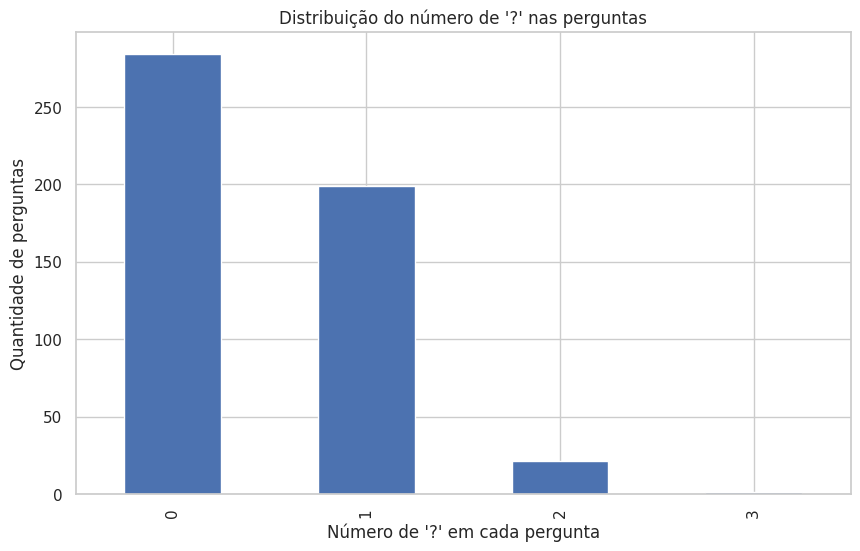

In [221]:
# considera caracteres '?' seguidos como um somente
chat_clients_csv['Pergunta'] = chat_clients_csv['Pergunta'].dropna().apply(lambda x: re.sub(r'\?+', '?', x))

chat_clients_csv['num_questions'] = chat_clients_csv['Pergunta'].apply(lambda x: x.count('?'))

count = chat_clients_csv['num_questions'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
count.plot(kind='bar')
plt.xlabel("Número de '?' em cada pergunta")
plt.ylabel("Quantidade de perguntas")
plt.title("Distribuição do número de '?' nas perguntas")
plt.show()

### 7. Quais palavras são mais frequentes?


A frequência das palavras ajuda a identificar os principais temas procurados pelos usuários, além de ajudar na identificação de palavras-chaves que direcionam ao tema que se é abordado.

In [222]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [223]:
# Concatena todas as perguntas em uma única string
all_questions = ' '.join(chat_clients_csv['Pergunta'].dropna().astype(str))

# Converte para minúsculas e remover pontuação
all_questions = re.sub(r'[^\w\s]', '', all_questions.lower())

# Tokeniza o texto (separar em palavras)
words = word_tokenize(all_questions)


In [224]:
# Remove stopwords (palavras comuns que podem não ser úteis)
stop_words = set(stopwords.words('portuguese'))
filtered_words = [word for word in words if word not in stop_words]

# Conta a frequência de cada palavra
word_counts = Counter(filtered_words)

# Lista as 10 palavras mais frequentes
most_common_words = word_counts.most_common(10)

print("As 10 palavras mais frequentes são:")
for word, count in most_common_words:
    print(f"{word}: {count}")

As 10 palavras mais frequentes são:
boa: 144
remessa: 125
tarde: 108
dia: 106
dinheiro: 103
brasil: 102
bom: 99
conta: 92
quanto: 90
enviar: 89


### 8. Qual é a distribuição das classes de intenções das perguntas?

Verificar e compreender a distribuição das intenções favorece na personalização do atendimento, ou seja, é importante para entender o propósito das interações, tais como reclamações, dúvidas, etc.

<ipython-input-225-4404bb033a0b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


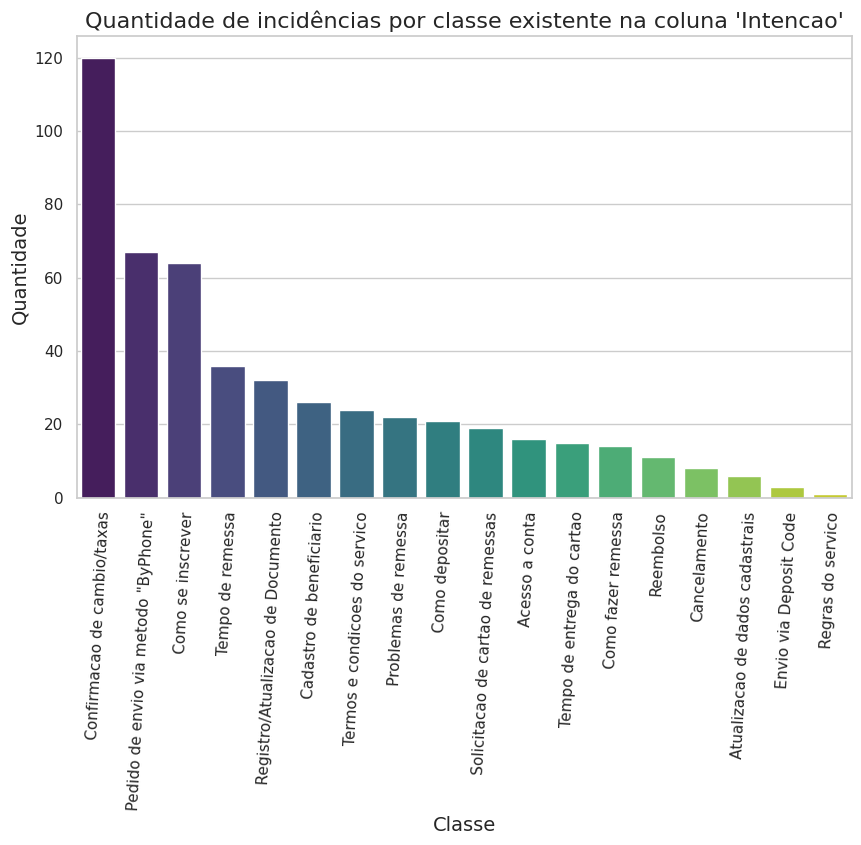

In [225]:
# calcula a frequência de cada valor
class_counts = chat_clients_csv['Intencao'].value_counts()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

plt.xlabel('Classe', fontsize=14)
plt.ylabel('Quantidade', fontsize=14)
plt.title("Quantidade de incidências por classe existente na coluna 'Intencao'", fontsize=16)
plt.xticks(rotation=87)  # Rotaciona os rótulos no eixo x para melhor legibilidade
plt.show()

### 9. Existe uma Correlação entre o Tamanho da Pergunta e o Tipo de Resposta Dada?

A correlação entre o tamanho da pergunta e o tamanho da resposta ajuda a determinar se há um padrão na forma como as perguntas são respondidas com base em sua extensão e complexidade. Se há uma correlação aparente, pode indicar proporcionalidade, ou seja, perguntas mais longas e detalhadas tendem a receber respostas mais longas, enquanto perguntas consideradas curtas geram respostas padrões ou mais simples.

In [226]:
# colunas de pergunta e resposta
chat_clients_csv['Pergunta'] = chat_clients_csv['Pergunta'].astype(str)
chat_clients_csv['Resposta'] = chat_clients_csv['Resposta'].astype(str)

# Calcula o comprimento de cada pergunta
chat_clients_csv['tamanho_pergunta'] = chat_clients_csv['Pergunta'].str.len()

# Calcula o comprimento de cada resposta
chat_clients_csv['tamanho_resposta'] = chat_clients_csv['Resposta'].str.len()

# Calcula a correlação entre o tamanho da pergunta e o tamanho da resposta
correlation_csv = chat_clients_csv['tamanho_pergunta'].corr(chat_clients_csv['tamanho_resposta'])

print(f"Correlação entre o tamanho da pergunta e o tamanho da resposta: {correlation_csv}")


Correlação entre o tamanho da pergunta e o tamanho da resposta: -0.06456208054134631


### 10. Qual a quantidade de tokens por pergunta?

Analisar a quantidade de tokens por pergunta é torna-se capaz de seguir pela lógica de que, se há mais tokens, normalmente indica que a pergunta é mais detalhada/complexa. A partir disso é possível compreender a complexidade das interações.

In [227]:
questions_csv = chat_clients_csv['Pergunta'].dropna()

# Função para contar tokens
def count_csv_tokens(texto):
    return len(nltk.word_tokenize(texto))

# Adicionar colunas para o número de tokens
chat_clients_csv['tokens_pergunta'] = questions_csv.apply(count_csv_tokens)

Estatísticas Descritivas - Tokens por Pergunta:
count    505.000000
mean      16.184158
std        9.479078
min        0.000000
25%       10.000000
50%       14.000000
75%       21.000000
max       71.000000
Name: tokens_pergunta, dtype: float64


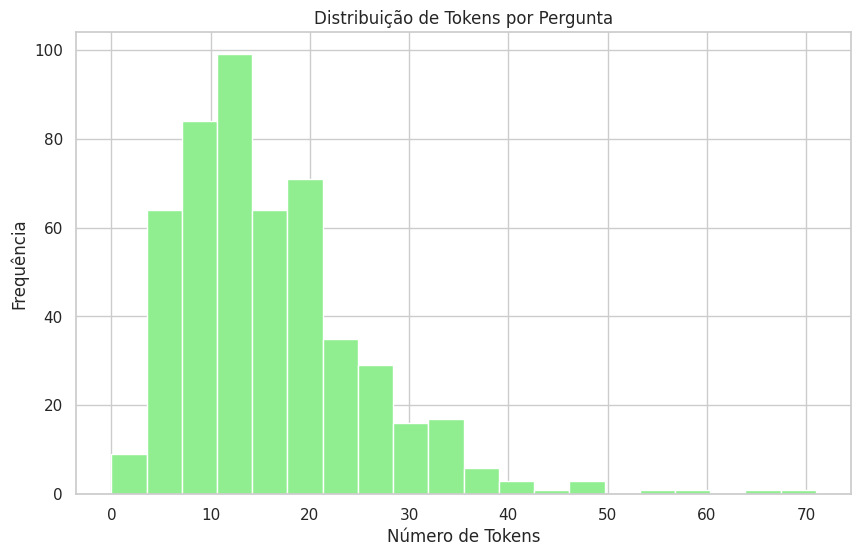

In [228]:
# Estatísticas descritivas
print("Estatísticas Descritivas - Tokens por Pergunta:")
print(chat_clients_csv['tokens_pergunta'].describe())

# Gráfico de Distribuição de tokens por Pergunta
plt.figure(figsize=(10, 6))
plt.hist(chat_clients_csv['tokens_pergunta'], bins=20, color='lightgreen')
plt.title('Distribuição de Tokens por Pergunta')
plt.xlabel('Número de Tokens')
plt.ylabel('Frequência')
plt.show()

### 11. Qual a quantidade de tokens por resposta

Assim como a quantidade de tokens por pergunta, a contagem de tokens por resposta esclarece o nível de detalhe das respostas fornecidas pelo modelo. Respostas mais longas remetem em um retorno mais detalhado, porém, nem sempre o que é detalhado será direto, esclarecedor e relevante, podendo indicar prolixidade.

In [229]:
answers_csv = chat_clients_csv['Resposta'].dropna()
chat_clients_csv['tokens_resposta'] = answers_csv.apply(contar_tokens)

Estatísticas Descritivas - Tokens por Resposta:
count    505.000000
mean      34.552475
std       24.992890
min        1.000000
25%       17.000000
50%       26.000000
75%       53.000000
max      189.000000
Name: tokens_resposta, dtype: float64


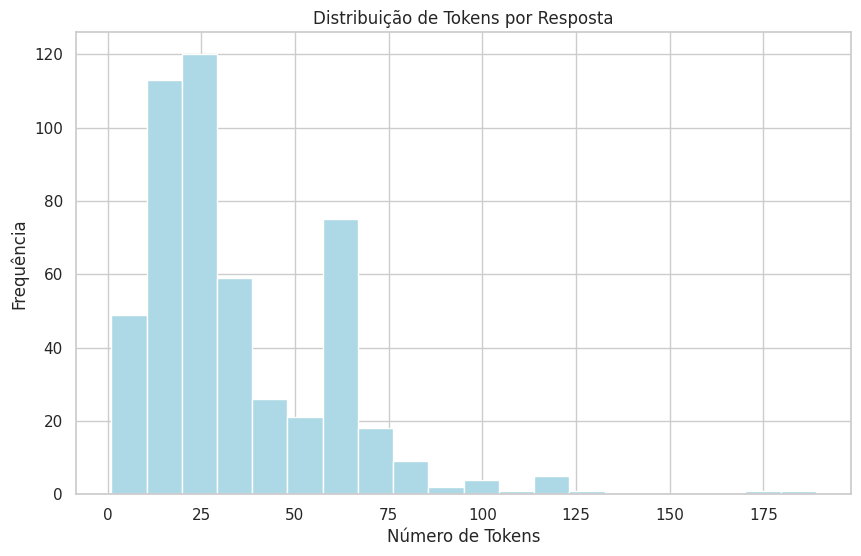

In [230]:
print("Estatísticas Descritivas - Tokens por Resposta:")
print(chat_clients_csv['tokens_resposta'].describe())

# Gráfico de Distribuição de Tokens por Resposta
plt.figure(figsize=(10, 6))
plt.hist(chat_clients_csv['tokens_resposta'], bins=20, color='lightblue')
plt.title('Distribuição de Tokens por Resposta')
plt.xlabel('Número de Tokens')
plt.ylabel('Frequência')
plt.show()

## Análise com Pandas Profilling

Nesta análise é utilizada a biblioteca Pandas Profilling para resumir toda a abordagem de análise exploratória referente aos dados do csv do cliente. Nessa análise é possível identificar os tipos de variáveis como categóricas, numéricas e textuais, a quantidade de cada uma assim como as interações e correlações. Ao selecionar "pergunta" no dropdown que se encontra na seção de "Variáveis" por exemplo, é possível vislumbrar as palavras que mais aparecem pelo seu tamanho, quanto maior é a palavra, quer dizer que aparece com mais frequência.

In [231]:
report = ProfileReport(chat_clients_csv)

In [232]:
report.to_notebook_iframe() # renderiza html

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [233]:
report.to_file("chat_clients_report.html") # download do arquivo html

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Análise sobre o conteúdo do FAQ

A base de dados disponibilizada em formato csv referente ao FAQ(Perguntas frequentes), encontra-se no idioma inglês em sua forma original. Desse modo, foi necessário transformar para o idioma português utilizando o Translator do Google.

In [234]:
# função para gerar tradução
def translate_to_portuguese(text):
    translator = Translator()
    translation = translator.translate(text, dest='pt') # idioma para português
    return translation.text

In [235]:
# guarda a aplicação da função de tradução
df_translated = faq_csv.applymap(translate_to_portuguese)
# monta o dataframe traduzido
df_translated.to_csv('/content/drive/Shareddrives/grupo3moshi/faq_translated.csv', index=False)

<ipython-input-235-025d923df922>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_translated = faq_csv.applymap(translate_to_portuguese)


In [236]:
translated_faq_csv = pd.read_csv('/content/drive/Shareddrives/grupo3moshi/faq_translated.csv') # lê arquivo

In [237]:
# mostra arquivo com o conteúdo traduzido
translated_faq_csv.head()

Pergunta  \
0                             O que é Remit Brastel?   
1  A Brastel Remit oferece o mesmo serviço que um...   
2  Existe alguma taxa de assinatura ou custo anua...   
3  Posso transferir dinheiro do exterior para o J...   
4  O destinatário da remessa pode ser uma empresa...   

                                            Resposta  
0  A Brastel Remit é um serviço em que os usuário...  
1  Não, a Brastel Remit não oferece transações de...  
2  Não. A associação é gratuita, sem taxas adicio...  
3  Não, atualmente o serviço está disponível apen...  
4  Sim, mas o destinatário deve ser um indivíduo ...

### 1. Qual o número total de perguntas?

In [238]:
# contador do total de perguntas
total_questions = translated_faq_csv['Pergunta'].count()
print("Número total de perguntas registradas: " + str(total_questions))

Número total de perguntas registradas: 37


###2. Qual o número total de respostas?

In [239]:
# contador do total de respostas
total_answers = translated_faq_csv['Resposta'].count()
print("Número total de respostas registradas: " + str(total_answers))

Número total de respostas registradas: 37


### 3. Todas as perguntas correspondem diretamente à um resposta?

Sim, o número de perguntas é de 37, assim como o número de respostas também é 37. Isso pode ser visto abaixo, confirmando que para cada pergunta há uma resposta.

In [240]:
# Verificação do número de colunas nulas, perguntas  e respostas
translated_faq_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pergunta  37 non-null     object
 1   Resposta  37 non-null     object
dtypes: object(2)
memory usage: 720.0+ bytes


### 4. Qual o tamanho médio das perguntas enviadas pelos clientes/usuários?

In [241]:
# tamanho de cada pergunta
len_questions = translated_faq_csv['Pergunta'].apply(len)
medium_question_size = len_questions.mean()
print("tamanho médio das perguntas recebidas: ", medium_question_size)

tamanho médio das perguntas recebidas:  70.05405405405405


### 5. Qual o tamanho médio das respostas listadas?

In [242]:
# calcula a média
medium_answer_size = translated_faq_csv['Resposta'].apply(len).mean()
print("tamanho médio das respostas listadas: ", medium_answer_size)

tamanho médio das respostas listadas:  149.2972972972973


### 6. Quais palavras são mais frequentes?

In [243]:
# downloads necessários para a transformação dos dados
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [244]:
# Concatena todas as perguntas em uma única string
all_questions = ' '.join(translated_faq_csv['Pergunta'].dropna().astype(str))

# Converte para minúsculas e remover pontuação
all_questions = re.sub(r'[^\w\s]', '', all_questions.lower())

# Tokeniza o texto (separar em palavras)
words = word_tokenize(all_questions)


In [245]:
# Remove stopwords
stop_words = set(stopwords.words('portuguese'))
filtered_words = [word for word in words if word not in stop_words]

# Conta a frequência de cada palavra
word_counts = Counter(filtered_words)

# Listar as 10 palavras mais frequentes
most_common_words = word_counts.most_common(10)

print("As 10 palavras mais frequentes são:")
for word, count in most_common_words:
    print(f"{word}: {count}")

As 10 palavras mais frequentes são:
brastel: 14
posso: 11
fazer: 8
remit: 7
remessa: 7
serviço: 6
dinheiro: 6
solicitação: 6
conta: 6
taxa: 5


### 7. Qual a quantidade de tokens por pergunta?

In [246]:
questions = translated_faq_csv['Pergunta'].dropna()

# Função para contar tokens
def count_tokens(texto):
    return len(nltk.word_tokenize(texto))

# Adicionar colunas para o número de tokens
translated_faq_csv['tokens_pergunta'] = questions.apply(count_tokens)

Estatísticas Descritivas - Tokens por Pergunta:
count    37.000000
mean     13.081081
std       4.946258
min       6.000000
25%       9.000000
50%      11.000000
75%      17.000000
max      25.000000
Name: tokens_pergunta, dtype: float64


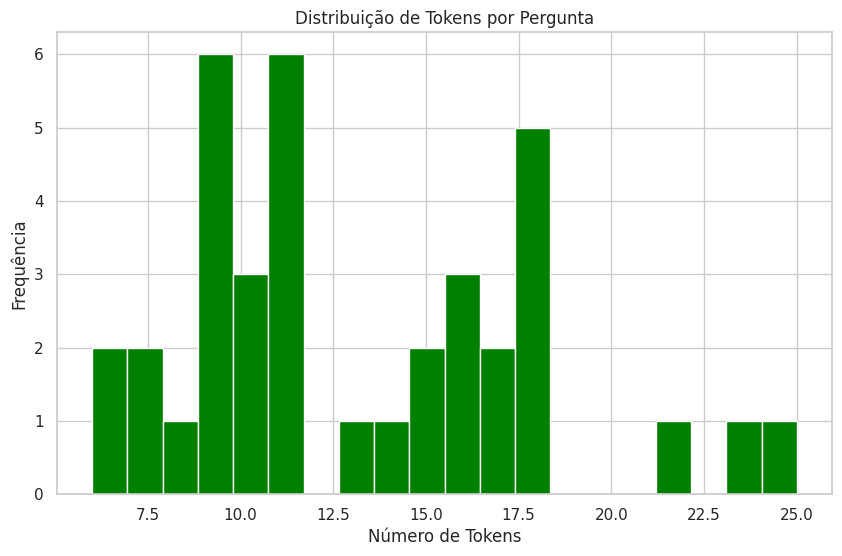

In [247]:
# Estatísticas descritivas
print("Estatísticas Descritivas - Tokens por Pergunta:")
print(translated_faq_csv['tokens_pergunta'].describe())

# Gráfico de Distribuição de Tokens por Pergunta
plt.figure(figsize=(10, 6))
plt.hist(translated_faq_csv['tokens_pergunta'], bins=20, color='green')
plt.title('Distribuição de Tokens por Pergunta')
plt.xlabel('Número de Tokens')
plt.ylabel('Frequência')
plt.show()

## 8. Qual a quantidade de tokens por respostas?

In [248]:
answers = translated_faq_csv['Resposta'].dropna()
translated_faq_csv['tokens_resposta'] = answers.apply(count_tokens)

Estatísticas Descritivas - Tokens por Resposta:
count    37.000000
mean     25.945946
std      10.143268
min      11.000000
25%      18.000000
50%      24.000000
75%      32.000000
max      48.000000
Name: tokens_resposta, dtype: float64


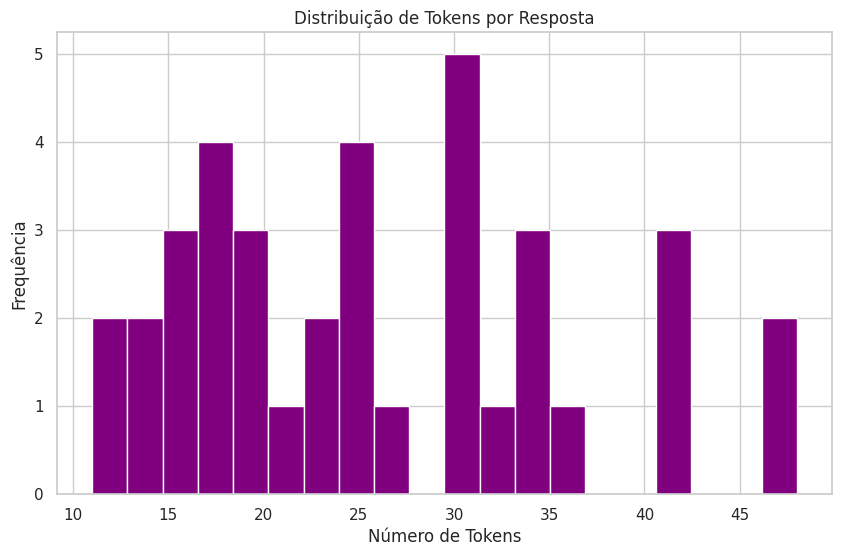

In [249]:
print("Estatísticas Descritivas - Tokens por Resposta:")
print(translated_faq_csv['tokens_resposta'].describe())

# Gráfico de Distribuição de Tokens por Resposta
plt.figure(figsize=(10, 6))
plt.hist(translated_faq_csv['tokens_resposta'], bins=20, color='purple')
plt.title('Distribuição de Tokens por Resposta')
plt.xlabel('Número de Tokens')
plt.ylabel('Frequência')
plt.show()

## Análise com Pandas Profilling(FAQ)


Assim como na seção de análise exploratória referente aos dados do csv, é feito o mesmo processo para os dados presentes no FAQ utilizando a biblioteca Pandas Profilling. Desse modo, temos um overview de todo o levantamento ao decorrer dessa seção, abordando as perguntas e as conclusões com os dados fornecidos.

In [250]:
report_faq = ProfileReport(translated_faq_csv)

In [251]:
report_faq.to_notebook_iframe() # renderiza html

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [252]:
report_faq.to_file("chat_clients_report.html") # download do arquivo html

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]